In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from tqdm import tqdm

from keybert import KeyBERT

import re

from wordcloud import WordCloud
from collections import defaultdict # 데이터프레임 만들때, 딕셔너리형 만들때 사용
import ast # 워드클라우드 전처리에 사용
from sklearn.feature_extraction.text import TfidfVectorizer # idf제거

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

# 데이터 분석

### 1) 문서 개수 파악

In [50]:
# 분석용 데이터 불러오기
# 이름, 연설날짜, 당선여부, 대선 연도, 전처리 하지 않은 연설, 1차 전처리 연설, 2차전처리 연설, 정당, 대통령연임횟수, idf만제거 연설문

df_anal = pd.read_csv(r"E:\est\kdt\project\president_prediction\data\speech_analysis.csv", index_col=0)
df_anal.head(2)

,name,date,elected,Year,speech_whole,speech_processed,speech_processed2,Party,Elections_Won,whole_remove_idf
0,Charles E. Hughes,1916-06-10,0.0,1916,Mr. Chairman and Delegates: I have not desired...,"['mr', 'chairman', 'delegates', 'desired', 'no...","['mr', 'chairman', 'delegates', 'desired', 'no...",Republican,0.0,Mr Chairman Delegates I desired nomination I w...
1,Woodrow Wilson,1916-09-02,1.0,1916,"Senator James, Gentlemen of the Notification C...","['senator', 'james', 'gentlemen', 'notificatio...","['senator', 'james', 'gentlemen', 'notificatio...",Democratic,2.0,James Gentlemen Notification Committee Fellow ...


In [51]:
# 해당 연도에 대한 후보자별 연설 횟수
# 연도당 후보 연설 자료가 몇개있는지 파악하기 위해서 필요함

years = []
speech_gap = []
data_cnt ={}
for year in range(1916, 2024, 4):
    name, cnt = np.unique(df_anal[['name']][df_anal['Year'] == year], return_counts=True)
    data_cnt[f'{name[0]}_{year}'] = cnt[0]
    data_cnt[f'{name[1]}_{year}'] = cnt[1]
    speech_gap.append(np.abs(cnt[0]-cnt[1]))
    speech_gap.append(np.abs(cnt[0]-cnt[1]))
    years.append(year)
    years.append(year)

df_cnt = pd.DataFrame(data_cnt.items(), columns=['name_year', 'speech_count'])
df_cnt['speech_gap'] = speech_gap
df_cnt['year'] = years
df_cnt = df_cnt.reindex(columns=['year', 'name_year', 'speech_count', 'speech_gap'])

df_cnt.tail(3)

,year,name_year,speech_count,speech_gap
51,2016,Hillary Clinton_2016,92,13
52,2020,Donald J. Trump_2020,8,55
53,2020,Joseph R. Biden_2020,63,55


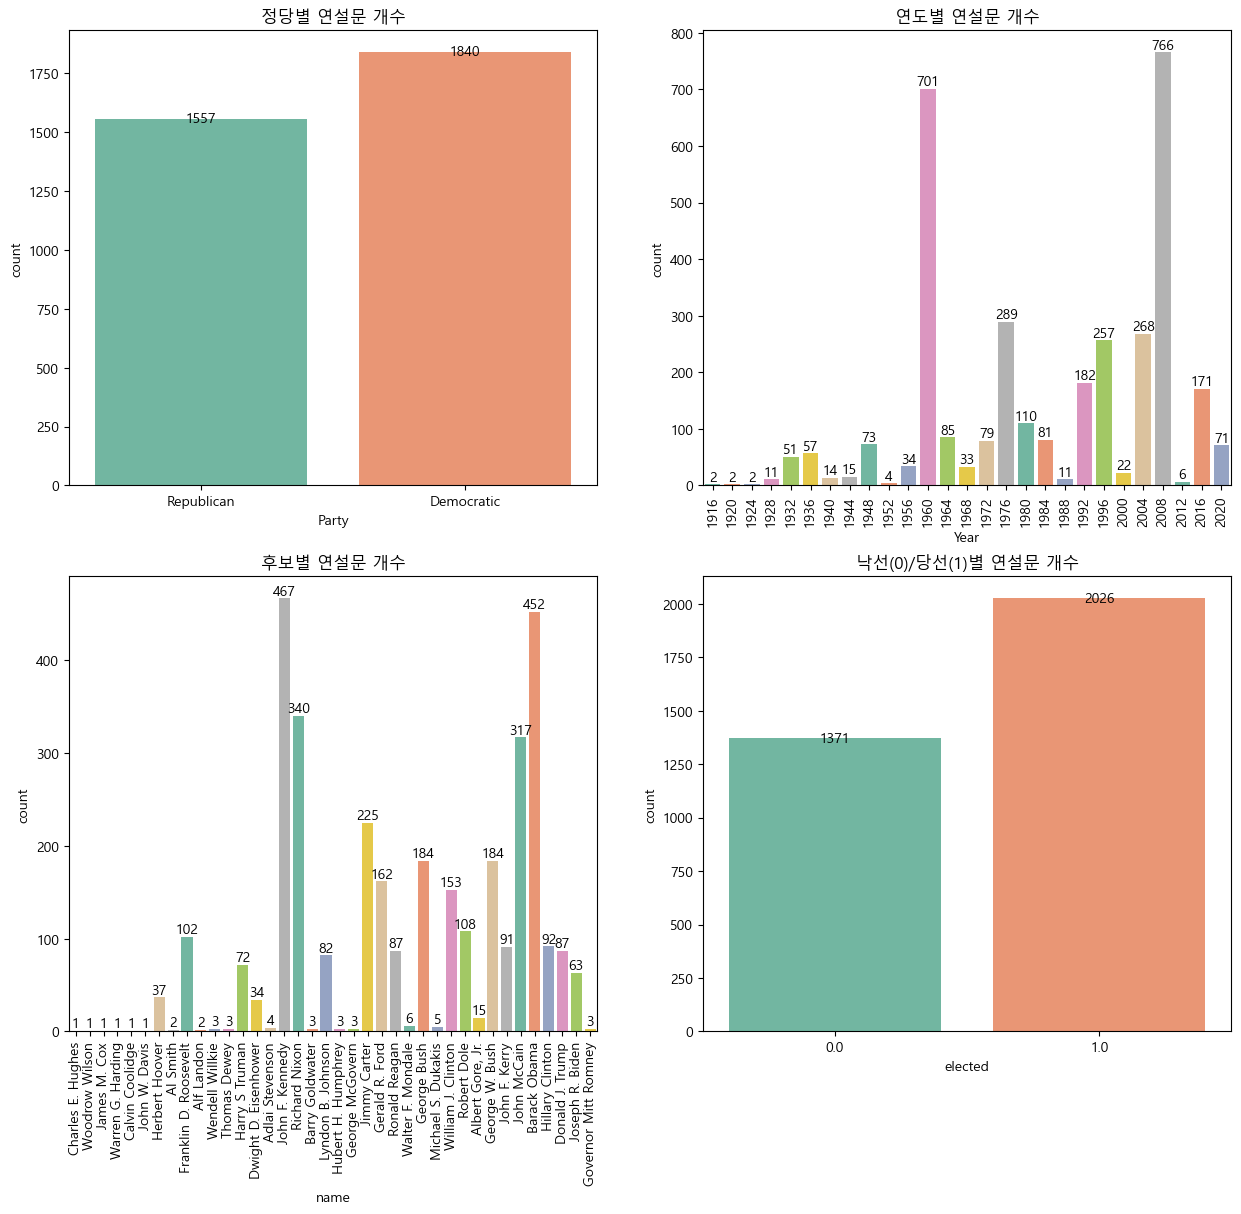

In [52]:
# 문서 개수
fig, axes = plt.subplots(2,2,figsize=(15, 13))
(ax1, ax2, ax3, ax4) = axes.flatten()

# 정당
sns.countplot(x='Party', data=df_anal, palette='Set2', ax=ax1)
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 0),
                textcoords = 'offset points')
ax1.set(title='정당별 연설문 개수')

# 연도
sns.countplot(x='Year', data=df_anal, palette='Set2', ax=ax2)
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
ax2.set(title='연도별 연설문 개수')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# 후보
sns.countplot(x='name', data=df_anal, palette='Set2', ax=ax3)
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
ax3.set(title='후보별 연설문 개수')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)

# 당낙선
sns.countplot(x='elected', data=df_anal, palette='Set2', ax=ax4)
for p in ax4.patches:
    ax4.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 0),
                textcoords = 'offset points')
ax4.set(title='낙선(0)/당선(1)별 연설문 개수')

plt.show()

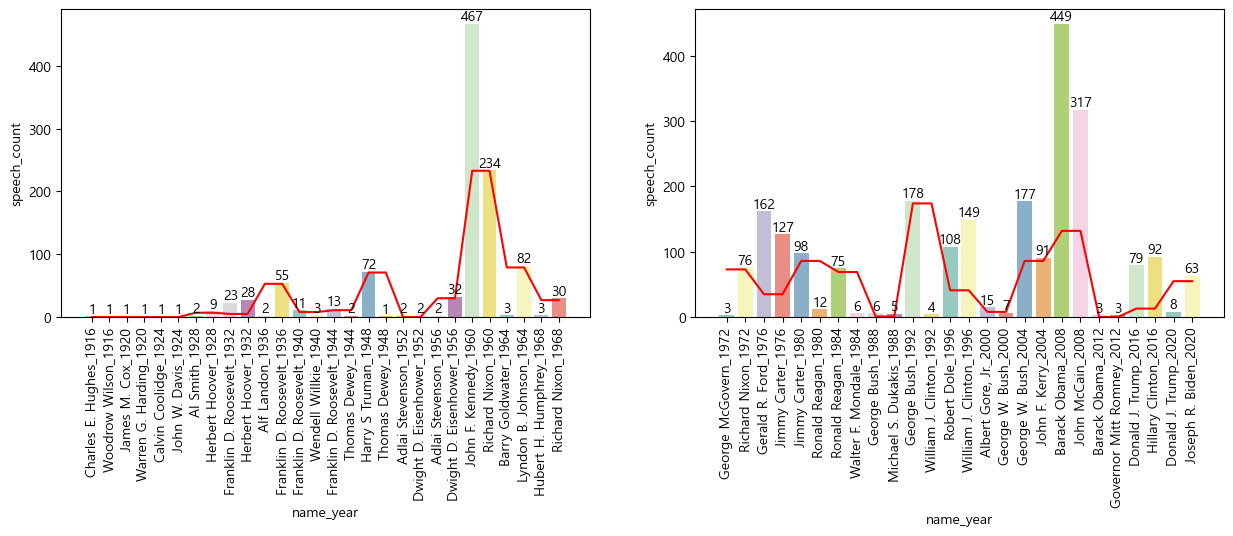

In [53]:
# 해당 연도에 대한 후보자별 문서 개수
fig, axes = plt.subplots(1,2,figsize=(15,4))
(ax1, ax2) = axes.flatten()

sns.barplot(x='name_year', y='speech_count', data=df_cnt[:28], palette='Set3', ax=ax1)
sns.lineplot(x='name_year', y='speech_gap', data=df_cnt[:28], color='red', ax=ax1)
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

sns.barplot(x='name_year', y='speech_count', data=df_cnt[28:], palette='Set3', ax=ax2)
sns.lineplot(x='name_year', y='speech_gap', data=df_cnt[28:], color='red', ax=ax2)
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

plt.show()

In [54]:
# 같은 연도에 연설문의 개수가 가장 차이 많이 나는 문서 확인
df_cnt.sort_values(['speech_gap', 'speech_count'], ascending=False)[:15]

,year,name_year,speech_count,speech_gap
22,1960,John F. Kennedy_1960,467,233
23,1960,Richard Nixon_1960,234,233
38,1992,George Bush_1992,178,174
39,1992,William J. Clinton_1992,4,174
46,2008,Barack Obama_2008,449,132
47,2008,John McCain_2008,317,132
44,2004,George W. Bush_2004,177,86
32,1980,Jimmy Carter_1980,98,86
45,2004,John F. Kerry_2004,91,86
33,1980,Ronald Reagan_1980,12,86


## 2. 분야별 분석

### 1. 분야별 키워드 빈도수 분석

- 연도/후보의 연설문(전처리x)에서 각 분야의 키워드 출현 횟수 데이터

In [55]:
df_anal_3 = pd.read_csv(r"E:\est\kdt\project\president_prediction\data\df_anal_3.csv", index_col=0)
df_anal_3.tail(2)

,Year,name,elected,Party,sci_cnt,econ_cnt,env_cnt,edu_cnt,sec_cnt
52,2020,Donald J. Trump,loss,Republican,19.0,26.0,18.0,23.0,29.0
53,2020,Joseph R. Biden,win,Democratic,15.0,22.0,15.0,21.0,21.0


In [56]:
# 당락별 그래프, 정당별 그래프 생성 함수

def field_count(df, field_cnt, field_name):
    yes_data = df[df['elected'] == 'win']
    no_data = df[df['elected'] == 'loss']
    do_data = df[df['Party'] == 'Democratic']
    re_data = df[df['Party'] == 'Republican']
    palette = sns.color_palette('Set2')
    yes_color = palette[0]
    no_color = palette[1]
    skyblue = '#4c72b0'
    coralred = '#c44e52'
    years = sorted(df['Year'].unique())

    fig, ax = plt.subplots(2, 1, figsize=(12, 12))
    (ax1, ax2) = ax.flatten()

    # 당락으로 구분
    ax1.bar(yes_data['Year'], yes_data[field_cnt], label='당선', color=yes_color, width=3)
    ax1.bar(no_data['Year'], no_data[field_cnt], label='낙선', color=no_color, width=1.5)
    ax1.set_title(f'연도별 {field_name} 키워드 등장 횟수(대선 당락)', fontsize=16)
    ax1.set_xlabel('4년 단위 연도')
    ax1.set_ylabel(f'{field_name} 키워드 등장 횟수')
    ax1.legend(title='대선 당락여부')
    ax1.set_xticks(years[::2]) # x 축 레이블을 2개당 하나씩 표시

    # 정당으로 구분
    ax2.bar(do_data['Year'], do_data[field_cnt], label='민주당', color=skyblue, width=3)
    ax2.bar(re_data['Year'], re_data[field_cnt], label='공화당', color=coralred, width=1.5)
    ax2.set_title(f'연도별 {field_name} 키워드 등장 횟수(정당)', fontsize=16)
    ax2.set_xlabel('4년 단위 연도')
    ax2.set_ylabel(f'{field_name} 키워드 등장 횟수')
    ax2.legend(title='정당')
    ax2.set_xticks(years[::2]) # x 축 레이블을 2개당 하나씩 표시

    plt.show()

#### 1) 과학 키워드로 빈도수 분석

In [57]:
# 각 분야별 상위 몇위까지 볼것인지 선택
rank = 16

In [58]:
# df_science = df_anal_2[['Year','name_year', 'elected', 'Party', 'sci_cnt']].sort_values('sci_cnt', ascending=False).reset_index(drop=True)[:rank]
df_science = df_anal_3[['Year','name', 'elected', 'Party', 'sci_cnt']].sort_values('sci_cnt', ascending=False).reset_index(drop=True)[:rank]
df_science

,Year,name,elected,Party,sci_cnt
0,1920,James M. Cox,loss,Democratic,36.0
1,1924,Calvin Coolidge,win,Republican,29.0
2,1916,Woodrow Wilson,win,Democratic,28.0
3,2012,Barack Obama,win,Democratic,25.0
4,1924,John W. Davis,loss,Democratic,25.0
5,1928,Herbert Hoover,win,Republican,23.0
6,2012,Governor Mitt Romney,loss,Republican,23.0
7,1920,Warren G. Harding,win,Republican,23.0
8,1928,Al Smith,loss,Democratic,22.0
9,1932,Franklin D. Roosevelt,win,Democratic,20.0


In [59]:
# 상위 14위에서 비율

print(df_science['elected'].value_counts())
print()
print(df_science['Party'].value_counts())

elected
win     11
loss     5
Name: count, dtype: int64

Party
Republican    9
Democratic    7
Name: count, dtype: int64


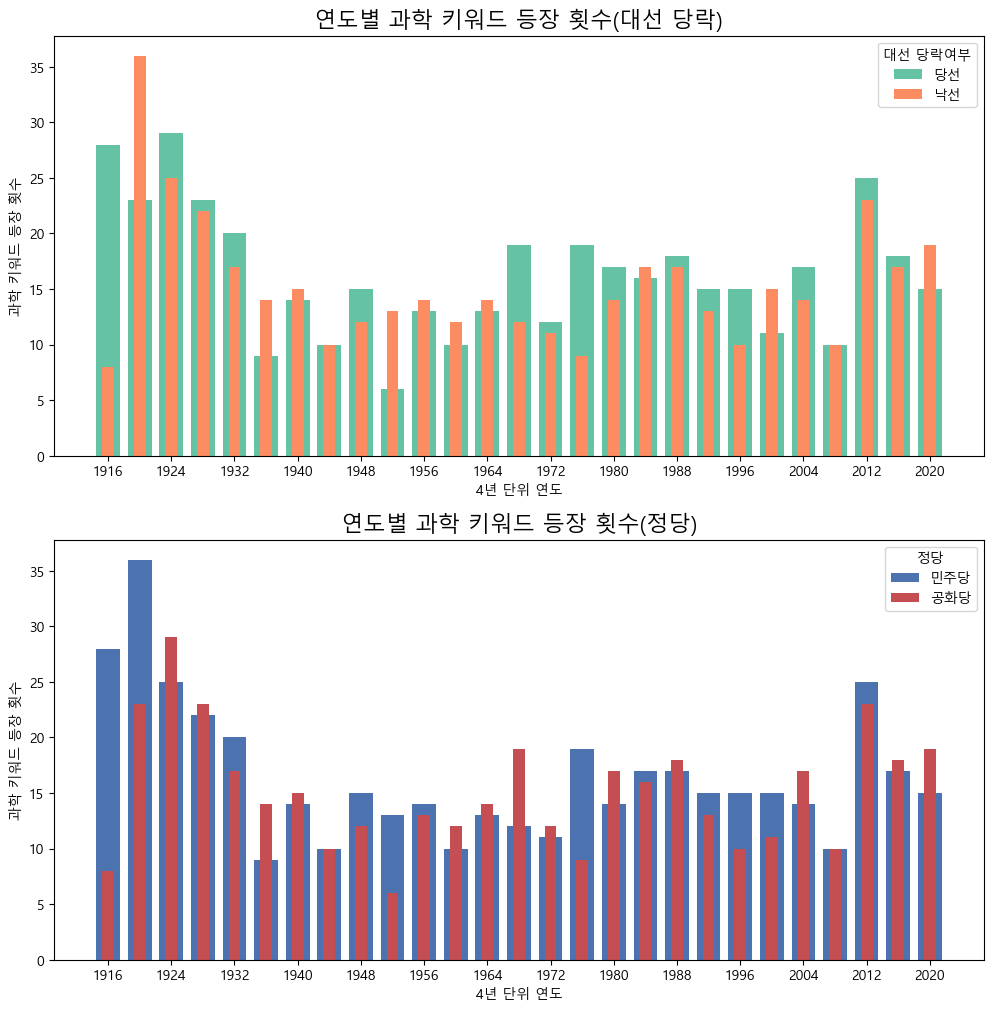

In [60]:
field_count(df_anal_3, 'sci_cnt', '과학')

#### 2) 경제 키워드로 빈도수 분석

In [61]:
# df_economy = df_anal_2[['Year','name_year', 'elected', 'Party', 'econ_cnt']].sort_values('econ_cnt', ascending=False).reset_index(drop=True)[:rank]
df_economy = df_anal_3[['Year','name', 'elected', 'Party', 'econ_cnt']].sort_values('econ_cnt', ascending=False).reset_index(drop=True)[:rank]
df_economy

,Year,name,elected,Party,econ_cnt
0,1920,James M. Cox,loss,Democratic,78.0
1,1924,John W. Davis,loss,Democratic,70.0
2,1924,Calvin Coolidge,win,Republican,64.0
3,1920,Warren G. Harding,win,Republican,63.0
4,1916,Woodrow Wilson,win,Democratic,54.0
5,1928,Herbert Hoover,win,Republican,54.0
6,2012,Barack Obama,win,Democratic,53.0
7,2012,Governor Mitt Romney,loss,Republican,52.0
8,1928,Al Smith,loss,Democratic,45.0
9,1932,Franklin D. Roosevelt,win,Democratic,44.0


In [62]:
# 상위 14위에서 비율

print(df_economy['elected'].value_counts())
print()
print(df_economy['Party'].value_counts())

elected
win     10
loss     6
Name: count, dtype: int64

Party
Republican    9
Democratic    7
Name: count, dtype: int64


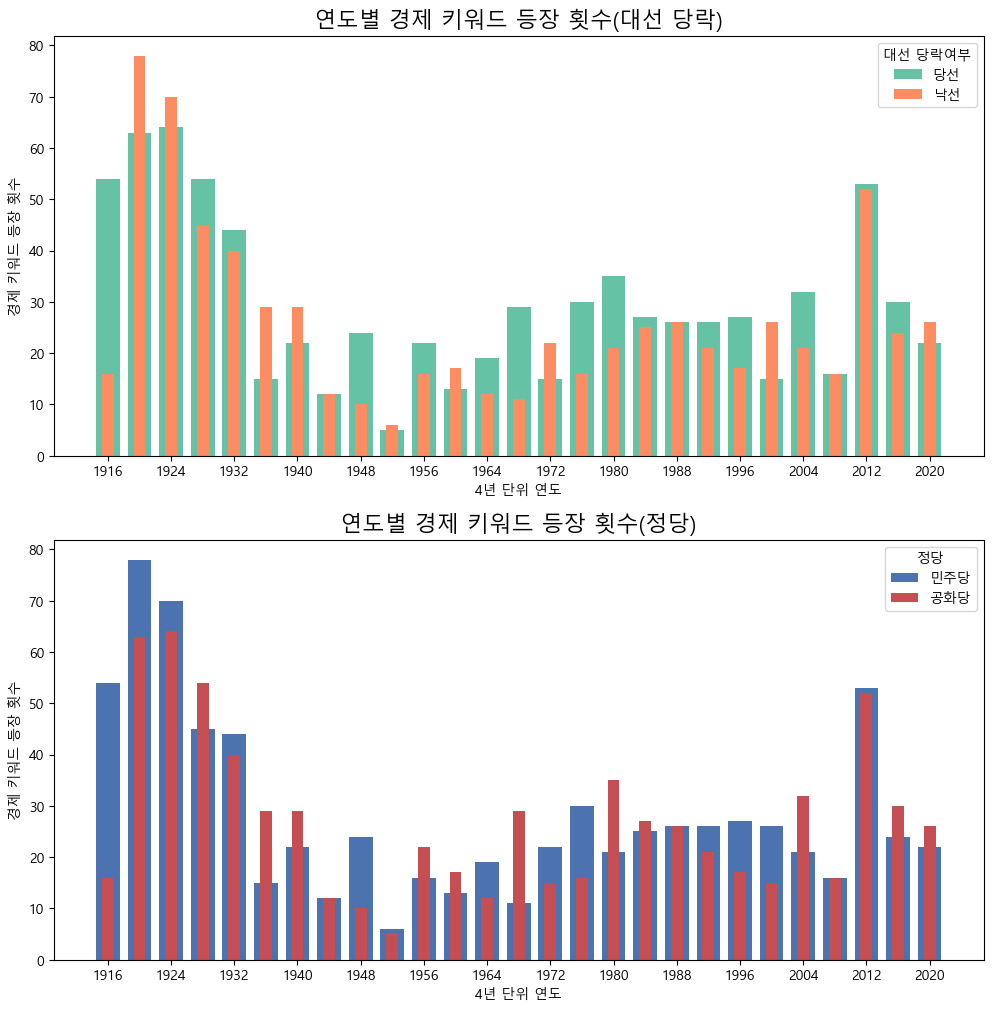

In [63]:
field_count(df_anal_3, 'econ_cnt', '경제')

#### 3) 환경 키워드로 빈도수 분석

In [64]:
# df_environment = df_anal_2[['Year','name_year', 'elected', 'Party', 'econ_cnt']].sort_values('econ_cnt', ascending=False).reset_index(drop=True)[:rank]
df_environment = df_anal_3[['Year','name', 'elected', 'Party', 'env_cnt']].sort_values('env_cnt', ascending=False).reset_index(drop=True)[:rank]
df_environment

,Year,name,elected,Party,env_cnt
0,1920,James M. Cox,loss,Democratic,45.0
1,1920,Warren G. Harding,win,Republican,40.0
2,1924,Calvin Coolidge,win,Republican,32.0
3,1924,John W. Davis,loss,Democratic,30.0
4,2012,Barack Obama,win,Democratic,28.0
5,2012,Governor Mitt Romney,loss,Republican,28.0
6,1916,Woodrow Wilson,win,Democratic,28.0
7,1928,Herbert Hoover,win,Republican,26.0
8,1928,Al Smith,loss,Democratic,23.0
9,1980,Ronald Reagan,win,Republican,23.0


In [65]:
# 상위 14위에서 비율

print(df_environment['elected'].value_counts())
print()
print(df_environment['Party'].value_counts())

elected
win     12
loss     4
Name: count, dtype: int64

Party
Republican    9
Democratic    7
Name: count, dtype: int64


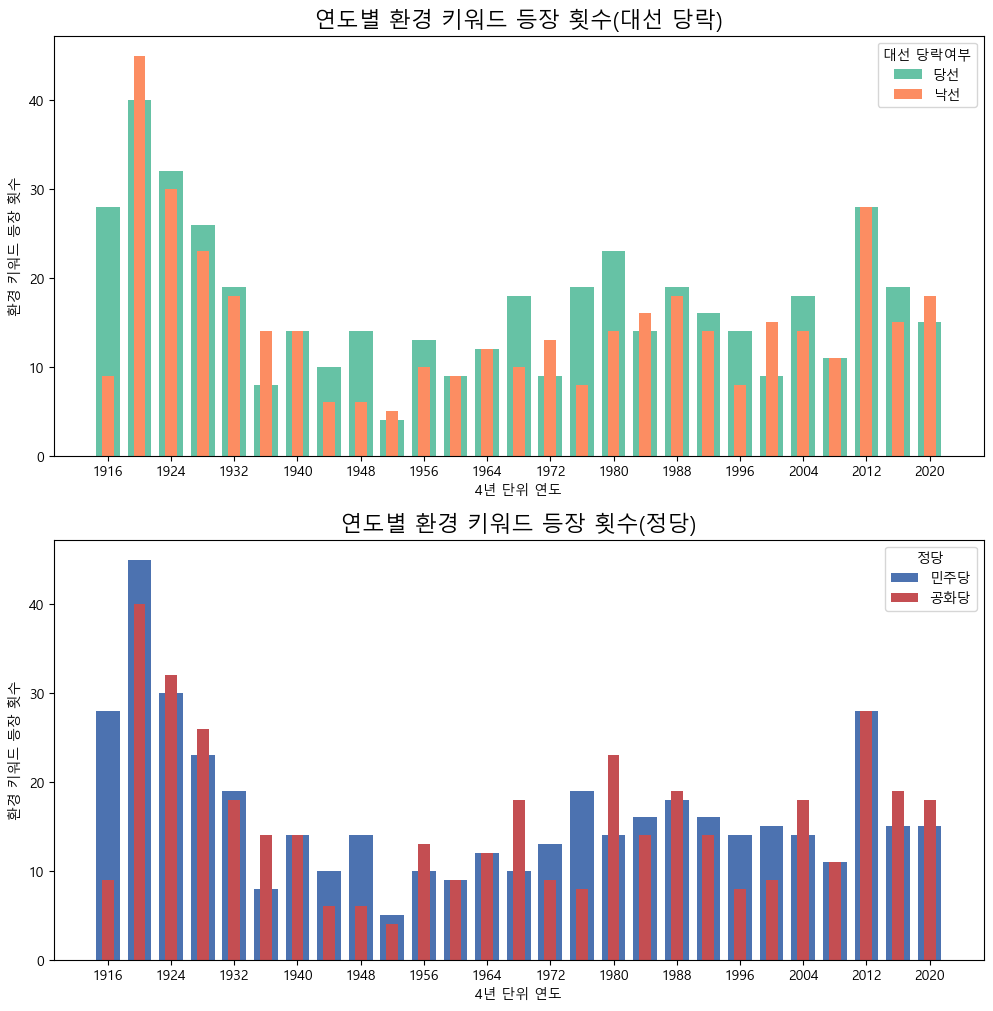

In [66]:
field_count(df_anal_3, 'env_cnt', '환경')

#### 4) 교육 키워드로 빈도수 분석

In [67]:
# 상위 14위에서 비율

# df_education = df_anal_2[['Year','name_year', 'elected', 'Party', 'edu_cnt']].sort_values('edu_cnt', ascending=False).reset_index(drop=True)[:rank]
df_education = df_anal_3[['Year','name', 'elected', 'Party', 'edu_cnt']].sort_values('edu_cnt', ascending=False).reset_index(drop=True)[:rank]
df_education

,Year,name,elected,Party,edu_cnt
0,1920,James M. Cox,loss,Democratic,65.0
1,1924,Calvin Coolidge,win,Republican,57.0
2,1924,John W. Davis,loss,Democratic,53.0
3,1920,Warren G. Harding,win,Republican,49.0
4,2012,Governor Mitt Romney,loss,Republican,48.0
5,2012,Barack Obama,win,Democratic,47.0
6,1916,Woodrow Wilson,win,Democratic,44.0
7,1928,Al Smith,loss,Democratic,39.0
8,1928,Herbert Hoover,win,Republican,39.0
9,1968,Richard Nixon,win,Republican,35.0


In [68]:
# 상위 14위에서 비율

print(df_education['elected'].value_counts())
print()
print(df_education['Party'].value_counts())

elected
win     11
loss     5
Name: count, dtype: int64

Party
Democratic    8
Republican    8
Name: count, dtype: int64


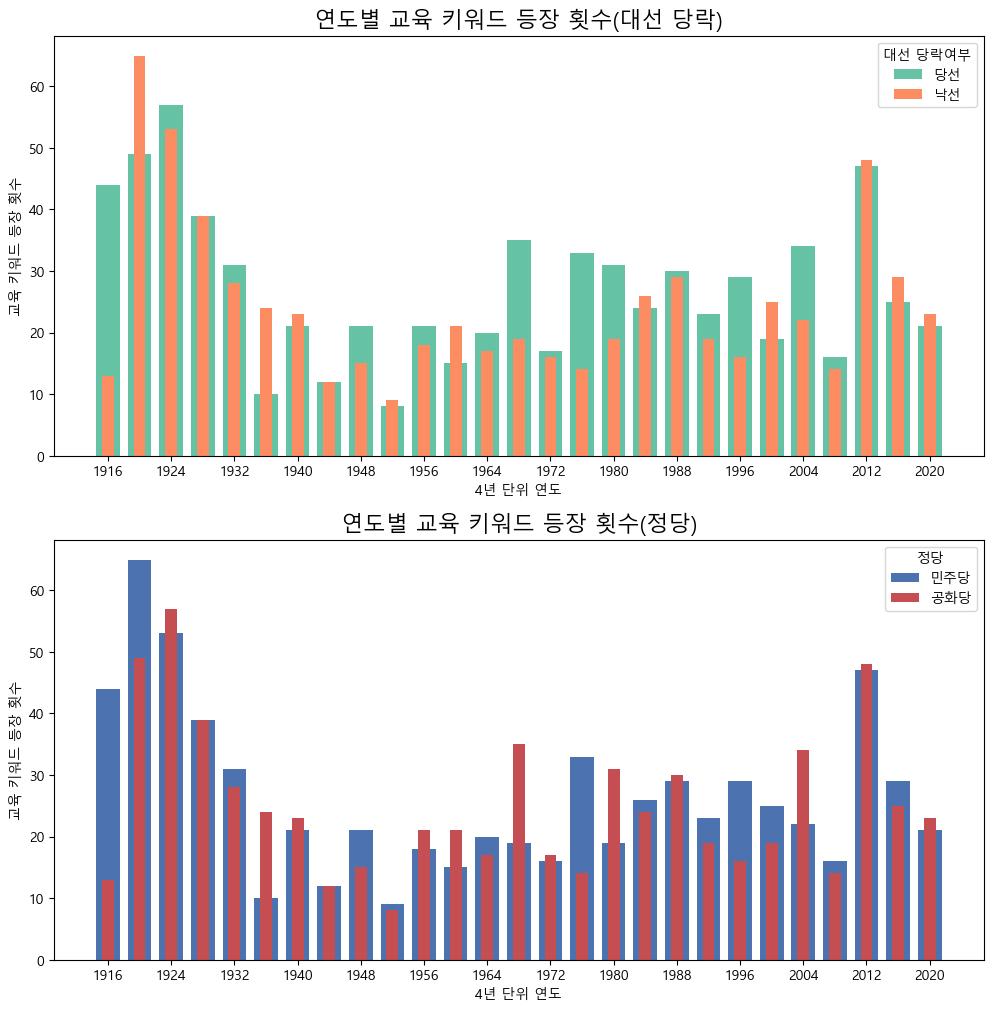

In [69]:
field_count(df_anal_3, 'edu_cnt', '교육')

#### 5) 안보 키워드로 빈도수 분석

In [70]:
# 상위 14위에서 비율

# df_security = df_anal_2[['Year','name_year', 'elected', 'Party', 'sec_cnt']].sort_values('sec_cnt', ascending=False).reset_index(drop=True)[:rank]
df_security = df_anal_3[['Year','name', 'elected', 'Party', 'sec_cnt']].sort_values('sec_cnt', ascending=False).reset_index(drop=True)[:rank]
df_security

,Year,name,elected,Party,sec_cnt
0,1920,James M. Cox,loss,Democratic,64.0
1,1920,Warren G. Harding,win,Republican,52.0
2,1924,John W. Davis,loss,Democratic,47.0
3,1916,Woodrow Wilson,win,Democratic,45.0
4,1924,Calvin Coolidge,win,Republican,44.0
5,2012,Barack Obama,win,Democratic,42.0
6,2012,Governor Mitt Romney,loss,Republican,35.0
7,1928,Al Smith,loss,Democratic,33.0
8,2016,Donald J. Trump,win,Republican,31.0
9,2004,George W. Bush,win,Republican,31.0


In [71]:
# 상위 14위에서 비율

print(df_security['elected'].value_counts())
print()
print(df_security['Party'].value_counts())

elected
win     10
loss     6
Name: count, dtype: int64

Party
Republican    9
Democratic    7
Name: count, dtype: int64


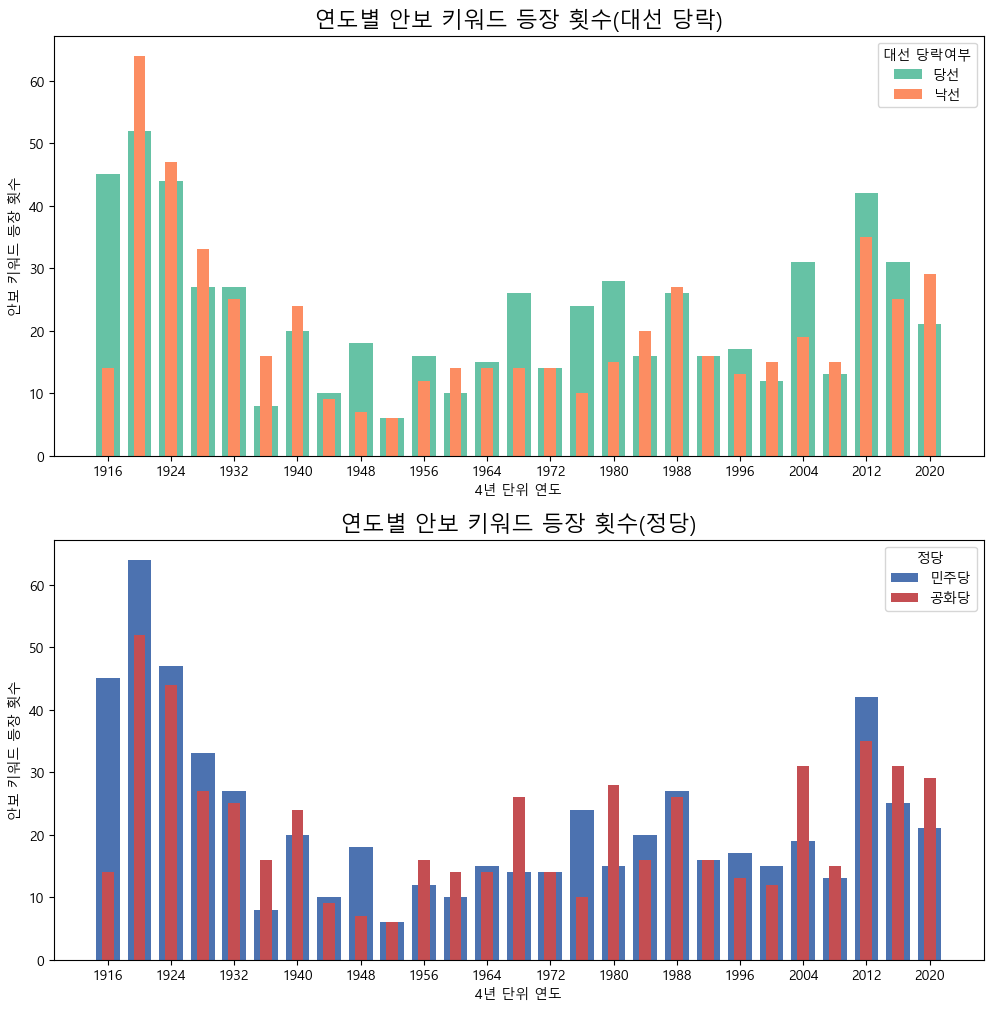

In [72]:
field_count(df_anal_3, 'sec_cnt', '안보')

### 2. KeyBERT
 - 연도별 / 후보별 / 대선 당락별 / 정당별 중요 키워드 분석

#### 2) 연도별 연설문 병합 - IDF 하위 181개 제거 연설문 keybert 분석 데이터프레임 생성

- 연도별로 문장(idf제거)

In [73]:
df_year_speech_2 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\year_speech_remove_idf.csv', index_col=0)

In [74]:
# 특정 연도 설정 및 keybert 분석 조회

i = 0 # 연도 설정(1916년~2020년) i = 0~26

print(df_year_speech_2.loc[i,'Year'], '\n', df_year_speech_2.loc[i,'keybert_year'])

1916 
 [('patriotic realization', 0.4102), ('nations subordinated', 0.3995), ('chairman delegates', 0.3922), ('responsibilities diplomatic', 0.3836), ('statesmanship', 0.3828), ('stand americanism', 0.3801), ('competent administrative', 0.3765), ('patriotism strength', 0.3748), ('ideals honorable', 0.3743), ('effort patriotic', 0.374), ('authority republic', 0.3737), ('sovereign authority', 0.3716), ('honorable', 0.3679), ('republics distrusted', 0.3674), ('respect sovereignty', 0.3671), ('constituted power', 0.3643), ('thorough americanism', 0.3627), ('candidates dictate', 0.3623), ('delegates desired', 0.3621), ('sovereignty await', 0.3601), ('international affairs', 0.3595), ('patriotic', 0.3574), ('partisan expediency', 0.357), ('competent', 0.3563), ('served traitorously', 0.3549), ('sovereignty weaker', 0.3547), ('pride honorable', 0.35), ('dealings nations', 0.348), ('democracy patriotism', 0.3476), ('nations stand', 0.3411)]


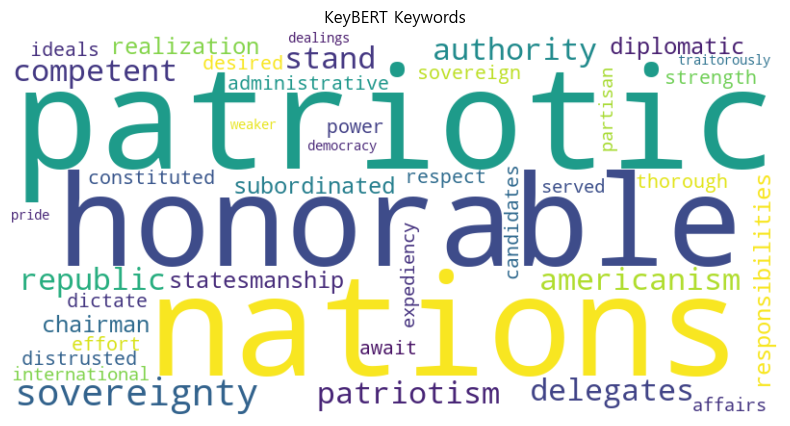

In [75]:
# 워드클라우드로 후보별 키워드 시각화

keybert_year_str_2 = df_year_speech_2.loc[i, 'keybert_year']
keybert_year_list_2 = ast.literal_eval(keybert_year_str_2)

# 키워드 추출
keywords = [kw[0] for kw in keybert_year_list_2]

# WordCloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))

# WordCloud 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('KeyBERT Keywords')
plt.show()

#### 2) 후보별 연설문 병합

In [76]:
df_name_speech_1 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\candidate_keywords.csv', index_col=0)
df_name_speech_1.head(2)

,name,Speech,keybert_name
0,1916_Charles E. Hughes,Mr. Chairman and Delegates: I have not desired...,"[('chairman delegates', 0.5029), ('desired nom..."
1,1916_Woodrow Wilson,"Senator James, Gentlemen of the Notification C...","[('senator james', 0.4726), ('wish democratic'..."


In [77]:
# 특정 후보 설정 및 keybert 분석 조회

i = 53 # 후보 설정(총 54명) i = 0~53

print(df_name_speech_1.loc[i,'name'], '\n', df_name_speech_1.loc[i,'keybert_name'])

2020_Joseph R. Biden 
 [('al qaeda', 0.3928), ('qaeda', 0.3927), ('afghanistan situation', 0.3718), ('qaeda isis', 0.3674), ('afghanistan thought', 0.363), ('laden raid', 0.3441), ('terrorists planning', 0.3401), ('terrorists stopped', 0.3368), ('laden', 0.3265), ('mistake terrorists', 0.3223), ('bin laden', 0.3172), ('afghanistan 2013', 0.3169), ('serving afghanistan', 0.3131), ('time afghanistan', 0.3122), ('iraq afghanistan', 0.3106), ('heads afghanistan', 0.3053), ('respond terrorist', 0.3022), ('terrorist activities', 0.2957), ('obama calling', 0.2926), ('terrorism plot', 0.2902), ('act terrorism', 0.2848), ('initiated barack', 0.2847), ('left afghanistan', 0.2811), ('administration relaunch', 0.2794), ('country terrorists', 0.279), ('afghanistan engaged', 0.2788), ('administration attacked', 0.2768), ('obama stopped', 0.272), ('trust barack', 0.272), ('wars afghanistan', 0.2693)]


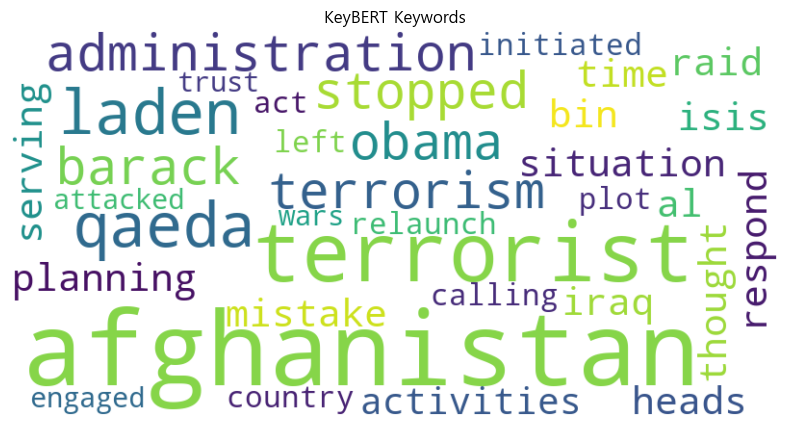

In [78]:
# 워드클라우드로 후보별 키워드 시각화

keybert_name_str = df_name_speech_1.loc[i, 'keybert_name']
keybert_name_list = ast.literal_eval(keybert_name_str)

# 키워드 추출
keywords = [kw[0] for kw in keybert_name_list]

# WordCloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))

# WordCloud 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('KeyBERT Keywords')
plt.show()

- 후보별 문장(idf제거)

In [79]:
df_name_speech_2 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\candidate_keywords_remove_idf.csv', index_col=0)
df_name_speech_2.head(2)

,name,Speech,keybert_name
0,1916_Charles E. Hughes,Mr Chairman Delegates I desired nomination I w...,"[('patriotic realization', 0.4102), ('nations ..."
1,1916_Woodrow Wilson,James Gentlemen Notification Committee Fellow ...,"[('candidates dictate', 0.4026), ('accept lead..."


In [80]:
# 특정 후보 설정 및 keybert 분석 조회

i = 53 # 후보 설정(총 54명) i = 0~53

print(df_name_speech_1.loc[i,'name'], '\n', df_name_speech_1.loc[i,'keybert_name'])

2020_Joseph R. Biden 
 [('al qaeda', 0.3928), ('qaeda', 0.3927), ('afghanistan situation', 0.3718), ('qaeda isis', 0.3674), ('afghanistan thought', 0.363), ('laden raid', 0.3441), ('terrorists planning', 0.3401), ('terrorists stopped', 0.3368), ('laden', 0.3265), ('mistake terrorists', 0.3223), ('bin laden', 0.3172), ('afghanistan 2013', 0.3169), ('serving afghanistan', 0.3131), ('time afghanistan', 0.3122), ('iraq afghanistan', 0.3106), ('heads afghanistan', 0.3053), ('respond terrorist', 0.3022), ('terrorist activities', 0.2957), ('obama calling', 0.2926), ('terrorism plot', 0.2902), ('act terrorism', 0.2848), ('initiated barack', 0.2847), ('left afghanistan', 0.2811), ('administration relaunch', 0.2794), ('country terrorists', 0.279), ('afghanistan engaged', 0.2788), ('administration attacked', 0.2768), ('obama stopped', 0.272), ('trust barack', 0.272), ('wars afghanistan', 0.2693)]


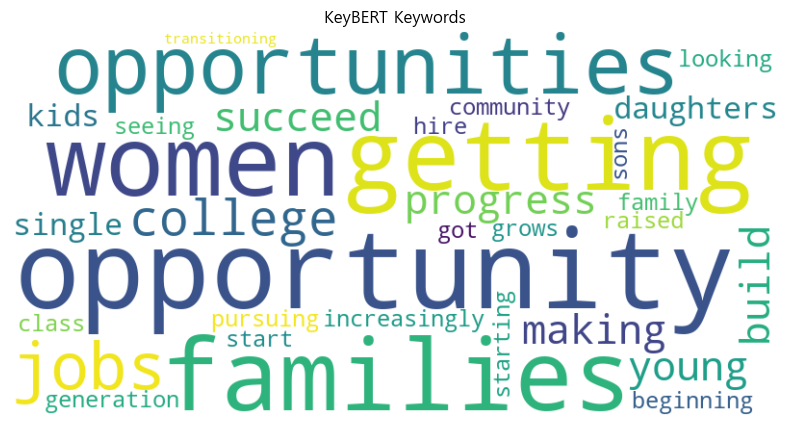

In [81]:
# 워드클라우드로 후보별 키워드 시각화

keybert_name_str_2 = df_name_speech_2.loc[i, 'keybert_name']
keybert_name_list_2 = ast.literal_eval(keybert_name_str_2)

# 키워드 추출
keywords = [kw[0] for kw in keybert_name_list_2]

# WordCloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))

# WordCloud 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('KeyBERT Keywords')
plt.show()

#### 3) 대선 당락별 연설문 병합

In [82]:
df_elected_speech_1 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\elected_outcome_keywords.csv', index_col=0)

In [83]:
# 대선 당락 설정 및 keybert 분석 조회

i = 0 # 당락 설정(낙선, 당선) i=0~1

print(df_elected_speech_1.loc[i,'elected'], '\n', df_elected_speech_1.loc[i,'keybert_name'])


0 
 [('distinguished patriotic', 0.4691), ('patriotic leadership', 0.4668), ('honorable patriotic', 0.4597), ('statesmanship command', 0.4589), ('received mandate', 0.4561), ('invoke patriotic', 0.4561), ('statements patriotic', 0.454), ('held statesmanlike', 0.4479), ('constitution command', 0.4458), ('commendation democratic', 0.4368), ('force patriotic', 0.4364), ('oath preside', 0.4356), ('allegation provide', 0.4353), ('identify competent', 0.4344), ('members patriotically', 0.434), ('democracy refrain', 0.4329), ('uphold sworn', 0.4321), ('form statesman', 0.4319), ('mandate described', 0.4292), ('vigorous mandate', 0.4289), ('commands allegiance', 0.4281), ('recognized mandate', 0.4277), ('unanimity patriotic', 0.4261), ('honorable leaders', 0.4246), ('statesmanship capable', 0.4242), ('patriotism statesmanship', 0.4223), ('patriotic posturing', 0.4222), ('delegates nations', 0.4219), ('abilities congressmen', 0.4211), ('capability diplomatic', 0.4209)]


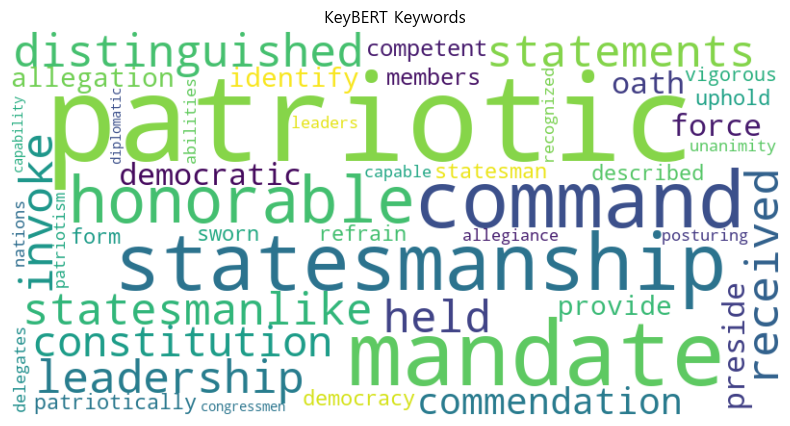

In [84]:
# 워드클라우드로 당락별 키워드 시각화

keybert_elected_str = df_elected_speech_1.loc[i, 'keybert_name']
keybert_elected_list = ast.literal_eval(keybert_elected_str)

# 키워드 추출
keywords = [kw[0] for kw in keybert_elected_list]

# WordCloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))

# WordCloud 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('KeyBERT Keywords')
plt.show()

```
1. 낙선 연설문 인사이트
- 애국심과 리더십: 국가에 대한 헌신과 리더십 자질 강조.
distinguished patriotic, patriotic leadership, honorable patriotic, invoke patriotic, unanimity patriotic, patriotic posturing

- 헌법과 법적 책임: 헌법과 법적 책임의 중요성 강조.
oath preside, uphold sworn, constitution command, received mandate, vigorous mandate, commands allegiance

- 리더십의 능력과 역량: 리더십의 역량과 능력, 외교적 역량 강조.
statesmanship command, statesmanship capable, identify competent, form statesman, patriotism statesmanship, capability diplomatic

- 정당 및 정치적 태도: 정당에 대한 언급과 정치적 태도 강조.
commendation democratic, allegation provide, democracy refrain, abilities congressmen, honorable leaders

- 정치적 경과와 상황: 정치적 입장과 상황 설명
statements patriotic, held statesmanlike, mandate described, recognized mandate, delegates nations


2. 당선 연설문 인사이트
- 리더십의 중요성: 강력하고 다양한 리더십 스타일을 강조.
assured leadership, ineptness leadership, asserting leadership, leadership assertive, disillusioned leadership, satisfied leadership, assertive leadership, leadership assured, thoughtful leadership, prudent leadership, leadership honest, leadership confident, honest leadership, unquestioned leadership, acknowledge leadership
리더십의 여러 측면이 언급되었습니다: assured (확신하는), assertive (단호한), thoughtful (사려 깊은), prudent (신중한), honest (정직한), confident (자신 있는), unquestioned (의심의 여지가 없는).

- 신뢰와 약속: 유권자들에게 신뢰를 주고, 약속을 지키겠다는 메시지.
promises leaders, candidates faithful, promises leadership, candidates promises

- 정당과의 연계: 자신의 리더십뿐만 아니라 소속 정당의 가치를 함께 강조.
parties reaffirms, party honorable, parties promises, obligation democrats

- 확신과 신뢰: 유권자들에게 확신을 주고 신뢰할 수 있는 지도자로서의 이미지 구축.
assured leadership, leadership confident, leadership honest, unquestioned leadership, acknowledge leadership
```

#### 3) 정당별 연설문 병합

In [85]:
df_party_speech_1 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\party_keywords.csv')

In [86]:
# 정당 설정 및 keybert 분석 조회

i = 1 # 정당 설정(공화당, 민주당) i=0~1

print(df_party_speech_1.loc[i,'Party'], '\n', df_party_speech_1.loc[i,'keybert_name'])


Democratic 
 [('assured leadership', 0.4656), ('sincerity republican', 0.461), ('asserting leadership', 0.4598), ('leadership assertive', 0.4567), ('disillusioned leadership', 0.4563), ('leaders affirm', 0.4512), ('satisfied leadership', 0.4479), ('parties reaffirms', 0.447), ('assertive leadership', 0.447), ('confidence congressman', 0.4469), ('thoughtful leaders', 0.4439), ('leadership assured', 0.4435), ('thoughtful leadership', 0.4423), ('assert leadership', 0.4419), ('confidence democrats', 0.4415), ('prudent leadership', 0.4412), ('leadership satisfied', 0.4409), ('leadership honest', 0.4407), ('promises leaders', 0.4406), ('candidates faithful', 0.4393), ('confident leadership', 0.4378), ('leadership confident', 0.4375), ('satisfied congressman', 0.4374), ('party honorable', 0.4364), ('obligation democrats', 0.4326), ('assure leadership', 0.4319), ('honest leadership', 0.4298), ('doubt leadership', 0.4297), ('parties promises', 0.4281), ('unquestioned leadership', 0.428)]


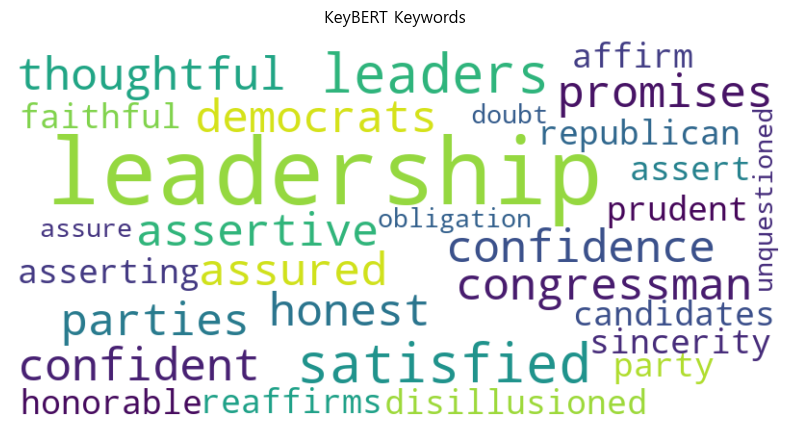

In [87]:
# 워드클라우드로 정당별 키워드 시각화

keybert_party_str = df_party_speech_1.loc[i, 'keybert_name']
keybert_party_list = ast.literal_eval(keybert_party_str)

# 키워드 추출
keywords = [kw[0] for kw in keybert_party_list]

# WordCloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))

# WordCloud 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('KeyBERT Keywords')
plt.show()

```
1. 공화당의 역대 연설문에서 주요하게 다뤄진 주제
- 애국심과 리더십: 애국적 언어와 리더십 자질의 강조.
distinguished patriotic, patriotic leadership, honorable patriotic, statements patriotic, unanimity patriotic, patriotic posturing, aligned patriotic.

- 헌법과 법적 책임: 헌법과 법적 책임에 대한 충실성.
oath preside, uphold sworn, received mandate, duty statesmanship, mandate described, vigorous mandate

- 리더십의 능력과 정직성: 리더십의 역량과 도덕적 기준.
competent principled, statesmanship capable, rectitude statesmanship, honorable leaders, capability diplomatic.

- 정당의 명성 및 단합: 정당의 명성과 내부 단합 강조.
honorable form, delegation pleased, honorable leaders, delegates nations

- 전략적 언급과 외교적 역할: 외교적 역량과 시민 동원.
capability diplomatic, mobilization citizen, patriotism capable, statesmanship adhere


2. 민주당의 역대 연설문에서 강조된 주요 주제
- 리더십의 강조: 리더십의 확신과 능력 강조, 다양한 리더십 스타일을 부각.
assured leadership, asserting leadership, leadership assertive, disillusioned leadership, satisfied leadership, assertive leadership, leadership assured, thoughtful leadership, prudent leadership, confident leadership, honest leadership, unquestioned leadership

- 정당의 명성과 약속: 정당의 신뢰성과 약속을 지키려는 강조.
sincerity republican, parties reaffirms, parties promises, promises leaders, candidates faithful, obligation democrats, party honorable

- 리더십의 다양한 측면: 사려 깊고 신중하며 정직한 리더십 강조.
thoughtful leaders, prudent leadership, leadership honest, leadership satisfied, doubt leadership

- 정당 간의 비교와 차별화: 공화당과의 차별화를 통한 민주당의 신뢰성과 진정성 강조.
sincerity republican, confidence democrats, obligation democrats

- 리더십의 신뢰와 약속: 리더십의 신뢰성과 약속을 강조하며 유권자에게 확신 제공.
promises leaders, candidates faithful, leadership confident, unquestioned leadership, honest leadership
```